In [1]:
import pandas as pd
import numpy as np
import random
from helpers import *
import matplotlib.pyplot as plt
import dimod
import itertools
from dwave.system import DWaveSampler, FixedEmbeddingComposite

from minorminer.busclique import find_clique_embedding
#from dwave.embedding.chimera import find_clique_embedding
#from dwave.embedding.pegasus import find_clique_embedding
from hybrid.reference.kerberos import KerberosSampler
#from helpers.plots import plot_mi 

In [2]:
def prob(dataset, max_bins=10):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [min(len(np.unique(dataset[:, ci])), max_bins) for ci in range(num_columns)]

    freq, _ = np.histogramdd(dataset, bins)
    p = freq / np.sum(freq)
    return p

def shannon_entropy(p):
    """Shannon entropy H(X) is the sum of P(X)log(P(X)) for probabilty distribution P(X)."""
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)

def conditional_shannon_entropy(p, *conditional_indices):
    """Shannon entropy of P(X) conditional on variable j"""

    axis = tuple(i for i in np.arange(len(p.shape)) if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))

def mutual_information(p, j):
    """Mutual information between all variables and variable j"""
    return shannon_entropy(np.sum(p, axis=j)) - conditional_shannon_entropy(p, j)

def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z."""

    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

In [3]:
#random.seed(90)

## Load selected feature list
feature_list_df = pd.read_csv('data/feature_list_162.csv', header=None)
print("No. of selected features:", feature_list_df.shape[0])
feature_lists = feature_list_df.values.tolist()
feature_lists = [a[0] for a in feature_lists]

#random.shuffle(feature_lists)
#print(feature_lists[:20])

No. of selected features: 162


In [4]:
dataset_df = pd.read_csv("data/survey_dataset(arranging_DV).csv")
print("Shape of dataset:",dataset_df.shape)
print(dataset_df.head())

#dataset_col_list = list(dataset_df)
#need_to_remove_features = dataset_col_list[-64:-2]
#print(len(need_to_remove_features))
#part_feature_list = feature_lists[60:90]
#print(part_feature_list)

Shape of dataset: (751, 254)
   q1  q2_1  q3  q4  q5  q6  q7_1  q9  q10  q11  ...  q325  q326  q327  q328  \
0   1    27   2   1   1   3     4   1    1    3  ...     4     3     2     4   
1   2    24   2   1   1   3     4   1    1    3  ...     1     3     3     3   
2   1    27   2   1   1   3     4   1    1    1  ...     1     4     2     2   
3   2    22   2   1   1   3     4   1    1    3  ...     1     4     2     3   
4   1    28   2   1   1   3     4   1    1    6  ...     2     3     3     3   

   q329  q330  q331  q332  before_covid  after_covid  
0     4     4     4     2             9           18  
1     3     4     3     2             9           23  
2     3     2     3     2             9            9  
3     3     2     3     2            11            9  
4     3     2     2     2            11           12  

[5 rows x 254 columns]


In [5]:
survey_df_after = dataset_df[feature_lists+['after_covid']]
survey_df_before = dataset_df[feature_lists+['before_covid']]

#survey_df_after = pd.read_csv("data/survey_dataset(after_binary).csv")
#survey_df_before = pd.read_csv("data/survey_dataset(before_binary).csv")
print("shape of dataset(before):", survey_df_before.shape)
print("shape of dataset(after):", survey_df_after.shape)

shape of dataset(before): (751, 163)
shape of dataset(after): (751, 163)


In [6]:
print(survey_df_before.head())
print(survey_df_after.head())

   q1  q2_1  q4  q11  q14  q18  q27  q29  q30  q31  ...  q324  q325  q326  \
0   1    27   1    3    1    1    1    2    2    2  ...     2     4     3   
1   2    24   1    3    1    1    1    2    2    2  ...     2     1     3   
2   1    27   1    1    1    1    2    2    2    2  ...     2     1     4   
3   2    22   1    3    1    1    1    2    2    2  ...     1     1     4   
4   1    28   1    6    1    1    1    2    2    2  ...     2     2     3   

   q327  q328  q329  q330  q331  q332  before_covid  
0     2     4     4     4     4     2             9  
1     3     3     3     4     3     2             9  
2     2     2     3     2     3     2             9  
3     2     3     3     2     3     2            11  
4     3     3     3     2     2     2            11  

[5 rows x 163 columns]
   q1  q2_1  q4  q11  q14  q18  q27  q29  q30  q31  ...  q324  q325  q326  \
0   1    27   1    3    1    1    1    2    2    2  ...     2     4     3   
1   2    24   1    3    1    1    1

In [7]:
def calculate_mi(dataset, DV):
    mi = {}
    features = list(set(dataset.columns).difference((DV,)))
    for feature in features:
        mi[feature] = mutual_information(prob(dataset[[DV, feature]].values), 1)
    mi_df = pd.DataFrame.from_dict(mi, orient='index')
    mi_df.columns=['Mutual information']
    return mi_df, mi

In [8]:
survey_df_after_mi_df, survey_df_after_mi = calculate_mi(survey_df_after, DV='after_covid')
survey_df_before_mi_df, survey_df_before_mi = calculate_mi(survey_df_before, DV='before_covid')

Mutual information between features in after dataset


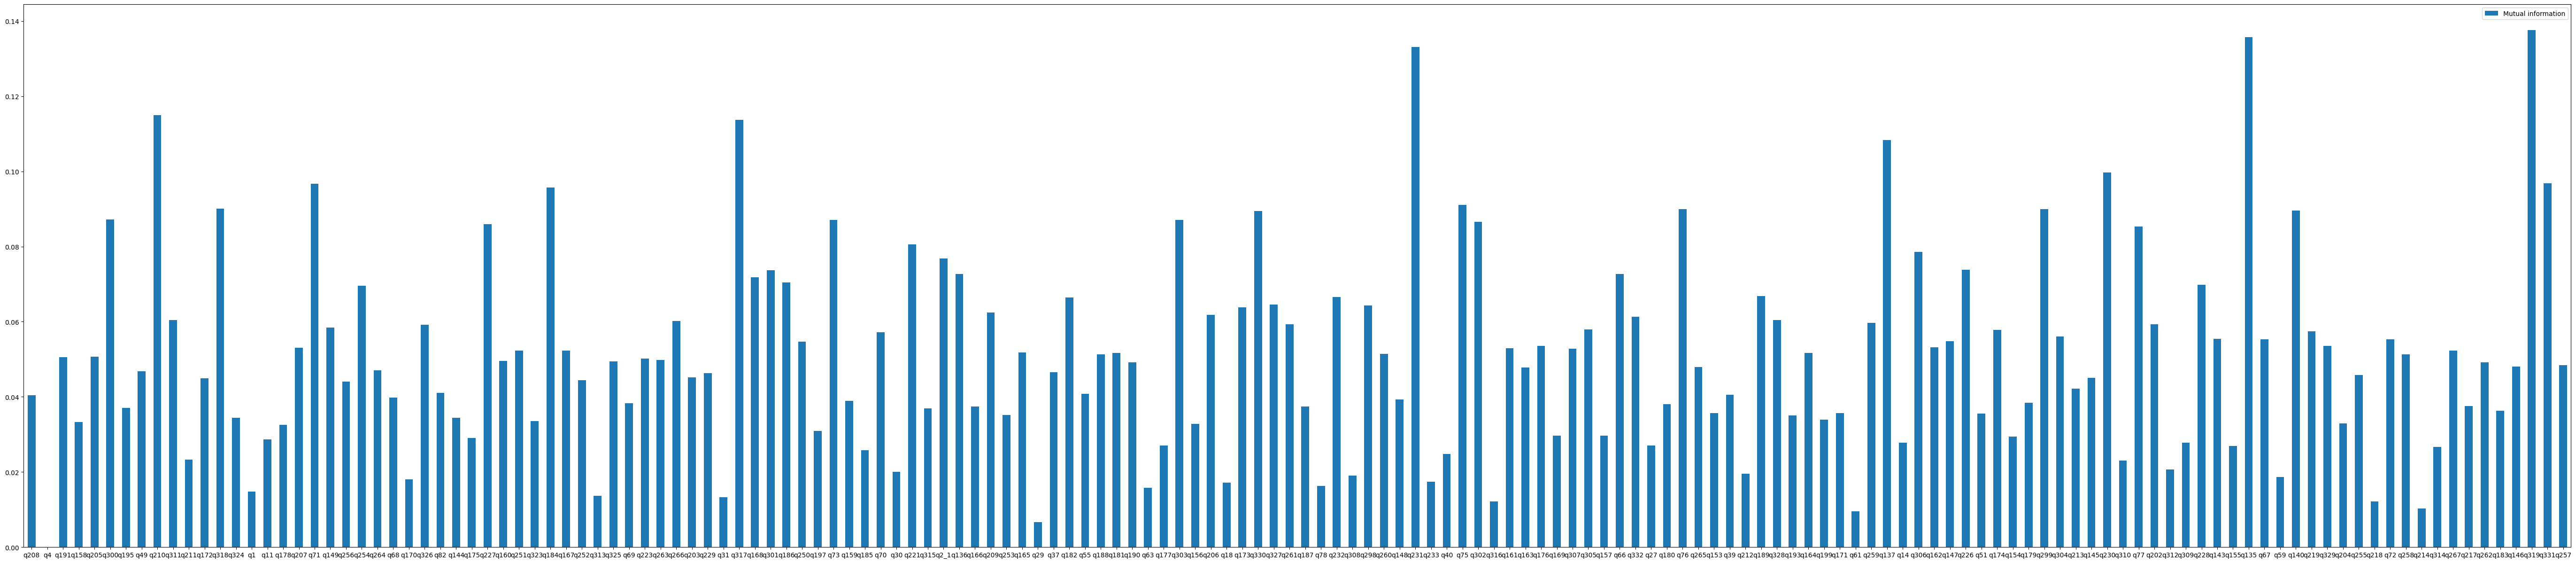

In [9]:
print("Mutual information between features in after dataset")
ax = survey_df_after_mi_df.plot.bar(rot=0, figsize=(70, 15))

Mutual information between features in before dataset


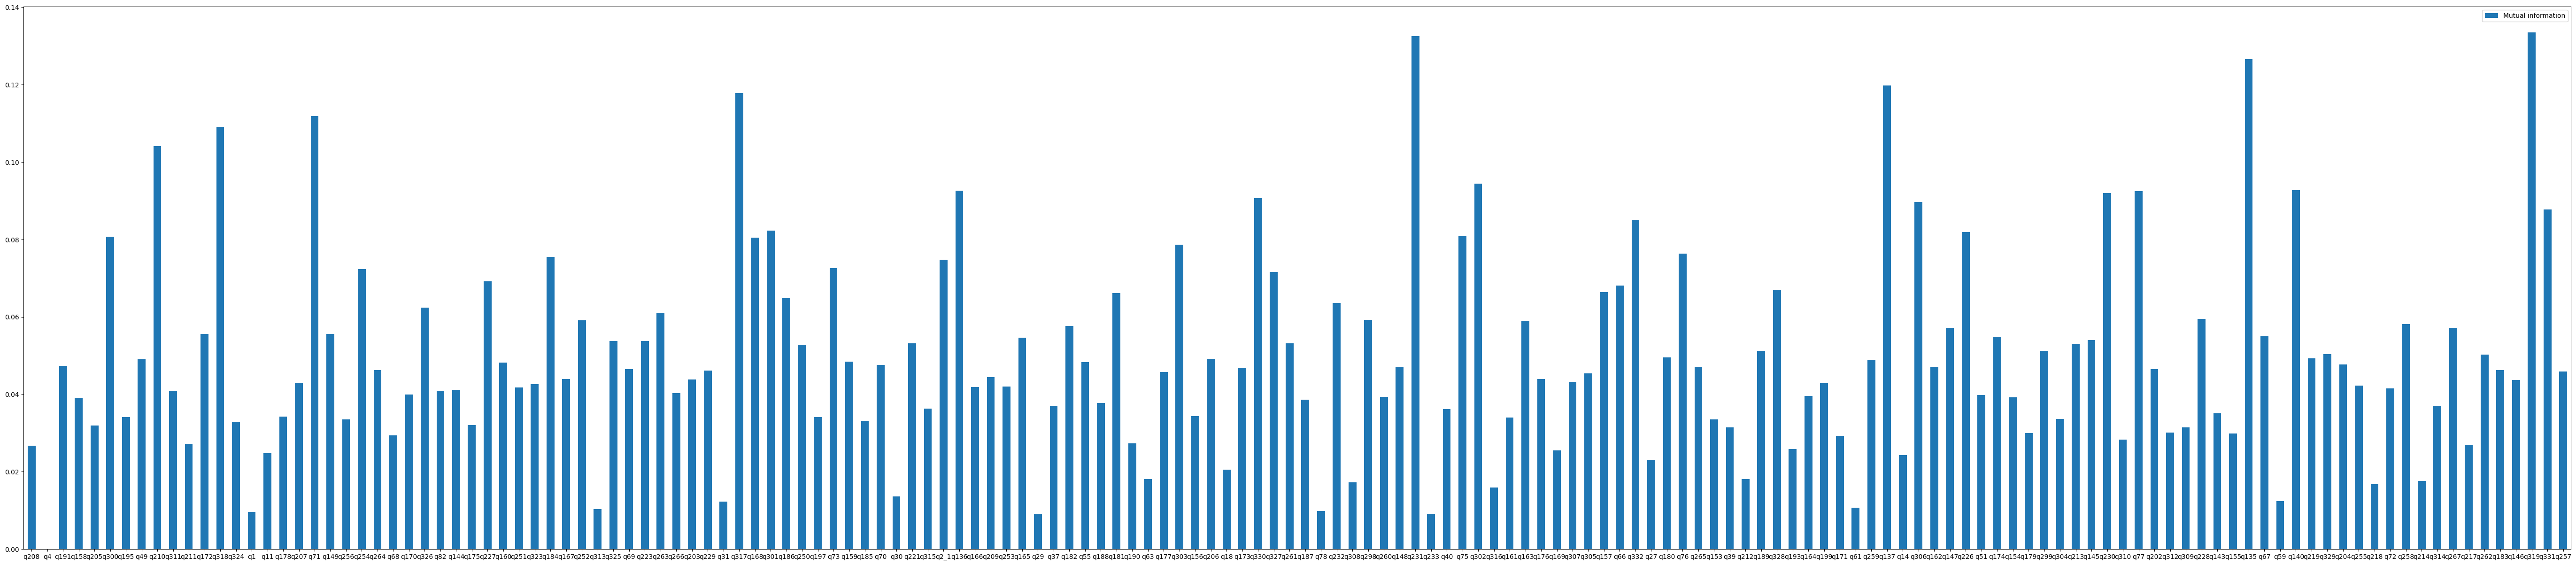

In [10]:
print("Mutual information between features in before dataset")
ax = survey_df_before_mi_df.plot.bar(rot=0, figsize=(70, 15))

In [11]:
def organized_feature(dataset, mi, keep, DV):
    sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
    dataset = dataset[[column[0] for column in sorted_mi[0:keep]] + [DV]]
    features = list(set(dataset.columns).difference((DV,)))
    print("Submitting for {} features: {}".format(keep, features))
    return features

In [12]:
features_after = organized_feature(survey_df_after, survey_df_after_mi, keep=int(survey_df_before.shape[1])-1, DV='after_covid')
features_before = organized_feature(survey_df_before, survey_df_before_mi, keep=int(survey_df_after.shape[1])-1, DV='before_covid')

Submitting for 162 features: ['q208', 'q4', 'q191', 'q300', 'q205', 'q158', 'q195', 'q49', 'q210', 'q311', 'q211', 'q318', 'q172', 'q324', 'q1', 'q11', 'q178', 'q207', 'q71', 'q149', 'q256', 'q254', 'q264', 'q68', 'q326', 'q170', 'q82', 'q144', 'q175', 'q227', 'q160', 'q251', 'q323', 'q184', 'q167', 'q252', 'q325', 'q313', 'q69', 'q223', 'q266', 'q263', 'q203', 'q229', 'q31', 'q317', 'q168', 'q301', 'q186', 'q250', 'q197', 'q73', 'q159', 'q185', 'q70', 'q221', 'q30', 'q315', 'q2_1', 'q136', 'q166', 'q209', 'q253', 'q165', 'q29', 'q37', 'q182', 'q188', 'q55', 'q181', 'q190', 'q63', 'q177', 'q303', 'q156', 'q206', 'q18', 'q173', 'q330', 'q327', 'q261', 'q187', 'q78', 'q232', 'q308', 'q298', 'q260', 'q148', 'q231', 'q233', 'q40', 'q75', 'q302', 'q316', 'q161', 'q163', 'q176', 'q169', 'q307', 'q305', 'q157', 'q66', 'q332', 'q27', 'q180', 'q76', 'q265', 'q153', 'q39', 'q212', 'q189', 'q328', 'q193', 'q164', 'q199', 'q171', 'q61', 'q259', 'q137', 'q14', 'q306', 'q162', 'q147', 'q226', 'q51',

In [13]:
def apply_BQM(dataset, features_, DV):
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # add the features
    for feature in features_:
        mi = mutual_information(prob(dataset[[DV, feature]].values), 1)
        bqm.add_variable(feature, -mi)

    for f0, f1 in itertools.combinations(features_, 2):
        cmi_01 = conditional_mutual_information(prob(dataset[[DV, f0, f1]].values), 1, 2)
        cmi_10 = conditional_mutual_information(prob(dataset[[DV, f1, f0]].values), 1, 2)
        bqm.add_interaction(f0, f1, -cmi_01)
        bqm.add_interaction(f1, f0, -cmi_10)

    bqm.normalize()
    return bqm 

In [14]:
bqm_after = apply_BQM(survey_df_after, features_after, DV='after_covid')
bqm_before = apply_BQM(survey_df_before, features_before, DV='before_covid')

In [15]:
def apply_DWave_sampler(bqm, features):
    qpu = DWaveSampler()

    qpu_working_graph = qpu.to_networkx_graph()
    print(qpu_working_graph)
    embedding = find_clique_embedding(bqm.variables, qpu_working_graph)
    #embedding = find_clique_embedding(bqm.variables, 16, 16, 4)
    print(embedding)
    qpu_sampler = FixedEmbeddingComposite(qpu, embedding)
    #print("\n Maximum chain length for minor embedding is {}.".format(max(len(x) for x in embedding.values())))

    kerberos_sampler = KerberosSampler()
    selected_features = np.zeros((len(features), len(features)))
    for k in range(1, len(features) + 1):
        print("Submitting for k={}".format(k))
        kbqm = dimod.generators.combinations(features, k, strength=6)
        kbqm.update(bqm)
        kbqm.normalize()
    
        best = kerberos_sampler.sample(kbqm, 
                                   qpu_sampler=qpu_sampler, 
                                   qpu_reads=1000, 
                                   max_iter=1,
                                   qpu_params={'label': 'Notebook - Feature Selection'}
                                  ).first.sample
    
        for fi, f in enumerate(features):
            selected_features[k-1, fi] = best[f]

    summed_each_cols = selected_features.sum(axis=0)
    organized_result_df = pd.DataFrame()
    organized_result_df['features'] = features
    organized_result_df['No_of_selected_features'] = summed_each_cols
    print("Shape of organized dataframe including selected features information:", organized_result_df.shape)
    return organized_result_df

In [16]:
selected_features_after = apply_DWave_sampler(bqm_after, features_after)
selected_features_before = apply_DWave_sampler(bqm_before, features_before)

91': (2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2982), 'q300': (2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2997), 'q158': (2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 3012), 'q205': (2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 3027), 'q195': (2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 3042), 'q49': (2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 3057), 'q210': (2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 3072), 'q311': (2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 3087), 'q211': (2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 3102), 'q318': (2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274,

In [17]:
selected_features_after.to_csv('data/selected_features_covid_after_result('+str(int(survey_df_after.shape[1])-1)+'features).csv', index=False)
selected_features_before.to_csv('data/selected_features_covid_before_result('+str(int(survey_df_before.shape[1])-1)+'features_3).csv', index=False)

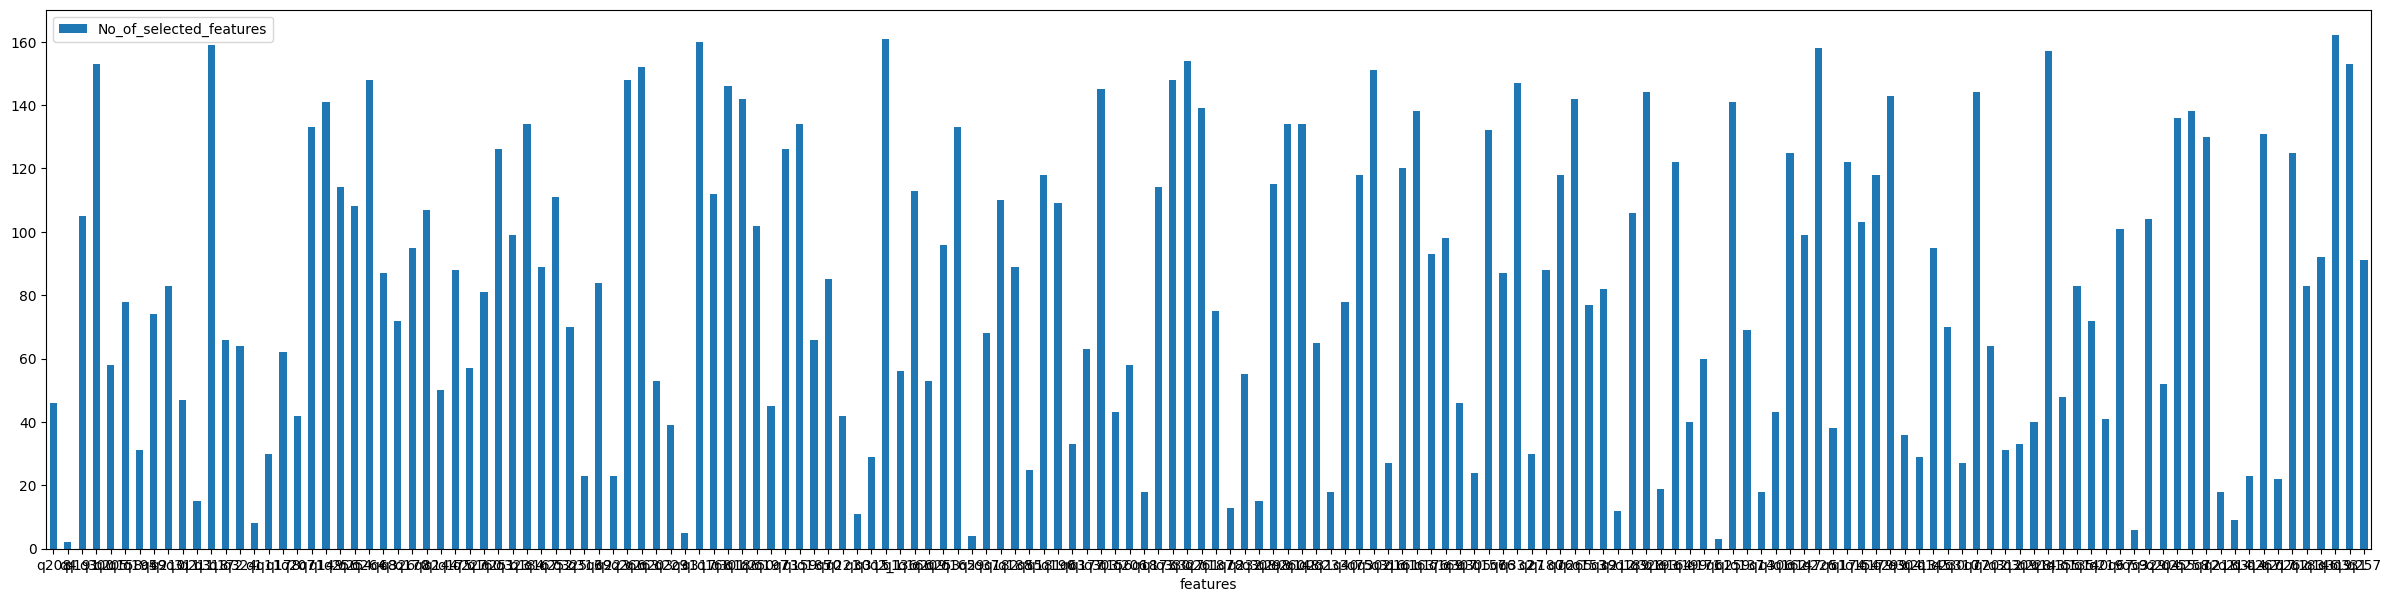

In [18]:
ax = selected_features_after.plot.bar(x = 'features',y='No_of_selected_features',rot=0, figsize=(30, 7))

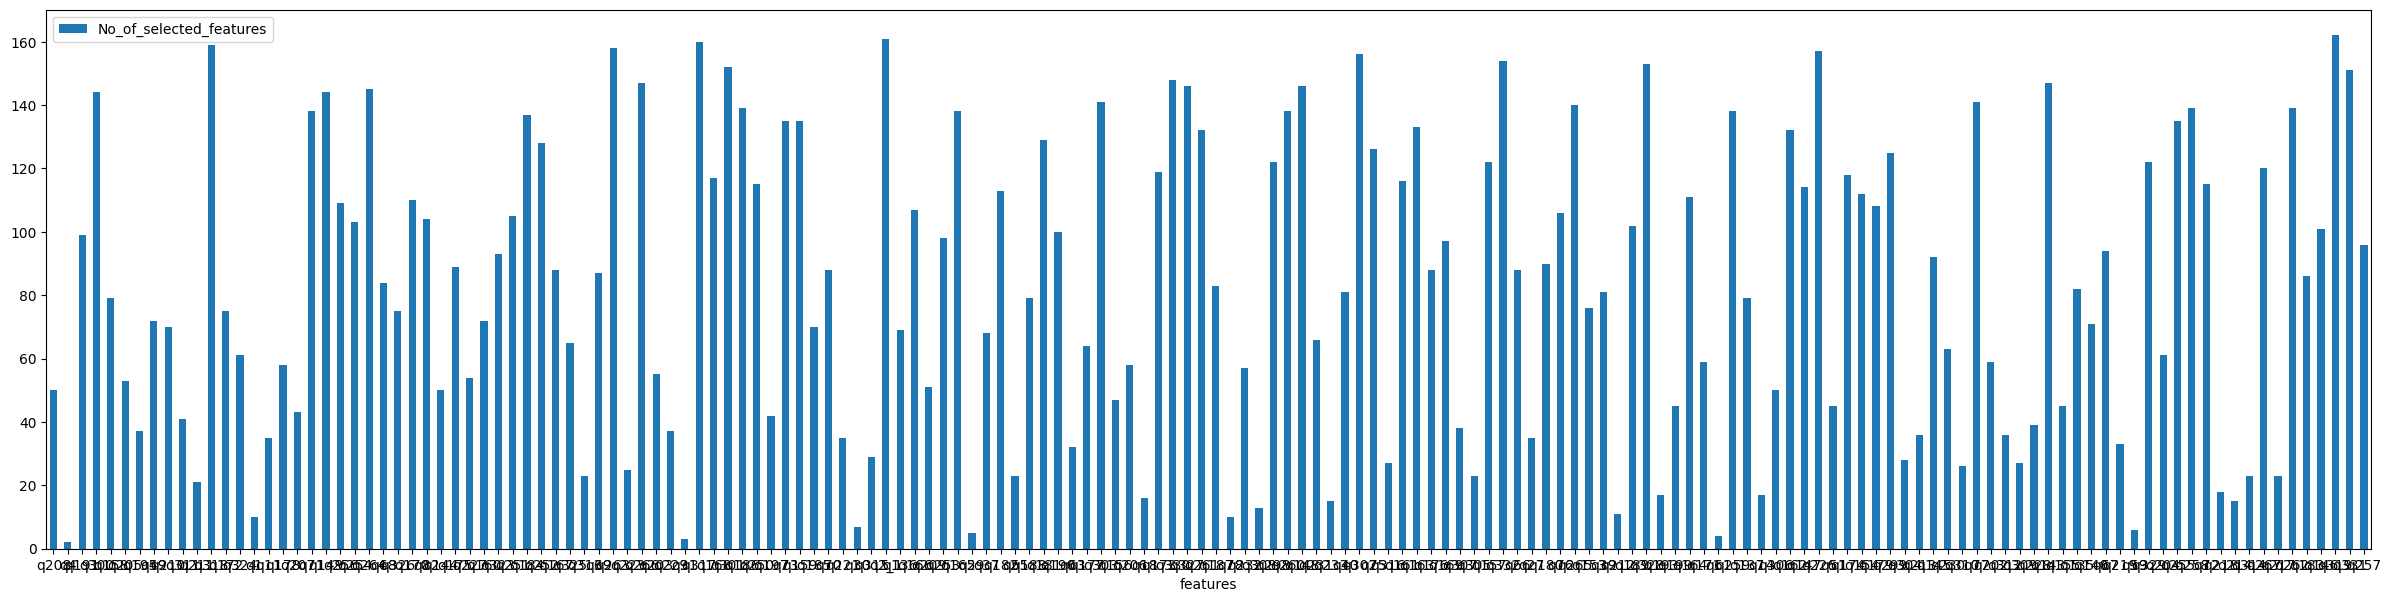

In [19]:
ax = selected_features_before.plot.bar(x = 'features',y='No_of_selected_features',rot=0, figsize=(30, 7))